In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
import pickle

In [3]:
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

from sklearn.datasets import load_iris, load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import ExtraTreesClassifier

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(555)

import matplotlib.pyplot
plt.style.use('ggplot')

In [4]:
from src.ga_attack_gibss import plot_graph, create_onehot_map, GA_Counterfactual, GAdvExample, alibi_ord_to_ohe, alibi_ohe_to_ord

2021-12-15 12:38:26.495028: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [5]:
data = pd.read_csv('./data/german_credit.csv')
y = data['default']
X_df = data.drop('default', axis=1)

cats = [X_df.dtypes.index[i] for i in range(X_df.shape[1]) if X_df.dtypes[i]=='object']
X_df = pd.get_dummies(X_df, columns=cats)

X = X_df.values
y = y.values

X_df.head()

,duration_in_month,credit_amount,installment_as_income_perc,present_res_since,age,credits_this_bank,people_under_maintenance,account_check_status_0 <= ... < 200 DM,account_check_status_< 0 DM,account_check_status_>= 200 DM / salary assignments for at least 1 year,account_check_status_no checking account,credit_history_all credits at this bank paid back duly,credit_history_critical account/ other credits existing (not at this bank),credit_history_delay in paying off in the past,credit_history_existing credits paid back duly till now,credit_history_no credits taken/ all credits paid back duly,purpose_(vacation - does not exist?),purpose_business,purpose_car (new),purpose_car (used),purpose_domestic appliances,purpose_education,purpose_furniture/equipment,purpose_radio/television,purpose_repairs,purpose_retraining,savings_.. >= 1000 DM,savings_... < 100 DM,savings_100 <= ... < 500 DM,savings_500 <= ... < 1000 DM,savings_unknown/ no savings account,present_emp_since_.. >= 7 years,present_emp_since_... < 1 year,present_emp_since_1 <= ... < 4 years,present_emp_since_4 <= ... < 7 years,present_emp_since_unemployed,personal_status_sex_female : divorced/separated/married,personal_status_sex_male : divorced/separated,personal_status_sex_male : married/widowed,personal_status_sex_male : single,other_debtors_co-applicant,other_debtors_guarantor,other_debtors_none,property_if not A121 : building society savings agreement/ life insurance,"property_if not A121/A122 : car or other, not in attribute 6",property_real estate,property_unknown / no property,other_installment_plans_bank,other_installment_plans_none,other_installment_plans_stores,housing_for free,housing_own,housing_rent,job_management/ self-employed/ highly qualified employee/ officer,job_skilled employee / official,job_unemployed/ unskilled - non-resident,job_unskilled - resident,telephone_none,"telephone_yes, registered under the customers name",foreign_worker_no,foreign_worker_yes
0,6,1169,4,4,67,2,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1
1,48,5951,2,2,22,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1
2,12,2096,2,3,49,1,2,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1
3,42,7882,2,4,45,1,2,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1
4,24,4870,3,4,53,2,2,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0,0,1,0,0,1


In [6]:
X.shape

(1000, 61)

In [7]:
clf = RandomForestClassifier()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.4)
clf.fit(X_train,y_train)
clf.score(X_test,y_test)

# logistic = SGDClassifier(loss='log', penalty='l1', early_stopping=True,
#                          max_iter=10000, tol=1e-5, random_state=0)
# sca = MinMaxScaler()
# clf = Pipeline(steps=[('sca', sca), ('logistic', logistic)])
# clf.fit(X,y)
# clf.score(X,y)

0.775

In [8]:
feature_names = list(X_df.columns)

In [9]:
_, one_hot = create_onehot_map(feature_names, sep="_", min_dist=1, data=None)
one_hot

{7: 4,
 11: 5,
 16: 10,
 26: 5,
 31: 5,
 36: 4,
 40: 3,
 43: 4,
 47: 3,
 50: 3,
 53: 4,
 57: 2,
 59: 2}

In [10]:
data_ = alibi_ohe_to_ord(X_train, one_hot)[0]
data_.shape, X_train.shape

((600, 20), (600, 61))

In [11]:
np.quantile(data_[:,0], np.linspace(0,1,5))

array([ 4., 12., 18., 24., 72.])

In [12]:
indp = np.where((clf.predict_proba(X_test)[:,1]<0.5) & (clf.predict_proba(X_test)[:,1]>0.4))
indp

(array([ 10,  13,  21,  25,  37,  57,  59,  66,  73,  83,  86, 112, 117,
        119, 123, 127, 134, 136, 145, 151, 172, 174, 180, 181, 198, 202,
        211, 213, 214, 226, 227, 238, 244, 247, 250, 252, 269, 281, 286,
        293, 304, 311, 316, 326, 336, 338, 346, 360, 383, 386, 394]),)

In [13]:
indn = np.where((clf.predict_proba(X_test)[:,1]<0.7) & (clf.predict_proba(X_test)[:,1]>0.5))
indn

(array([  9,  11,  16,  18,  29,  44,  51,  52,  55,  64,  65,  68,  71,
         72,  74,  75,  76,  79,  80,  81,  94, 106, 108, 114, 131, 132,
        141, 150, 152, 162, 164, 171, 173, 193, 209, 210, 212, 224, 232,
        236, 243, 245, 257, 261, 266, 270, 271, 273, 279, 303, 306, 307,
        314, 315, 324, 327, 329, 350, 357, 361, 362, 370, 372, 378, 380]),)

In [14]:
idx_test = 315

ga = GAdvExample(feature_names=feature_names,
                sol_per_pop=30, num_parents_mating=15, cat_vars_ohe=one_hot,
                 num_generations=100, n_runs=10, black_list=None,
                 verbose=False, beta=.96)

x_all, x_changes, x_sucess = ga.attack(clf, x=X_test[idx_test,:],x_train=X_train)

100%|███████████████████████████████████████████| 10/10 [00:42<00:00,  4.22s/it]


In [15]:
ga.results

,duration_in_month,credit_amount,installment_as_income_perc,present_res_since,age,credits_this_bank,people_under_maintenance,account_check_status_0 <= ... < 200 DM,account_check_status_< 0 DM,account_check_status_>= 200 DM / salary assignments for at least 1 year,account_check_status_no checking account,credit_history_all credits at this bank paid back duly,credit_history_critical account/ other credits existing (not at this bank),credit_history_delay in paying off in the past,credit_history_existing credits paid back duly till now,credit_history_no credits taken/ all credits paid back duly,purpose_(vacation - does not exist?),purpose_business,purpose_car (new),purpose_car (used),purpose_domestic appliances,purpose_education,purpose_furniture/equipment,purpose_radio/television,purpose_repairs,purpose_retraining,savings_.. >= 1000 DM,savings_... < 100 DM,savings_100 <= ... < 500 DM,savings_500 <= ... < 1000 DM,savings_unknown/ no savings account,present_emp_since_.. >= 7 years,present_emp_since_... < 1 year,present_emp_since_1 <= ... < 4 years,present_emp_since_4 <= ... < 7 years,present_emp_since_unemployed,personal_status_sex_female : divorced/separated/married,personal_status_sex_male : divorced/separated,personal_status_sex_male : married/widowed,personal_status_sex_male : single,other_debtors_co-applicant,other_debtors_guarantor,other_debtors_none,property_if not A121 : building society savings agreement/ life insurance,"property_if not A121/A122 : car or other, not in attribute 6",property_real estate,property_unknown / no property,other_installment_plans_bank,other_installment_plans_none,other_installment_plans_stores,housing_for free,housing_own,housing_rent,job_management/ self-employed/ highly qualified employee/ officer,job_skilled employee / official,job_unemployed/ unskilled - non-resident,job_unskilled - resident,telephone_none,"telephone_yes, registered under the customers name",foreign_worker_no,foreign_worker_yes,P0,P1
0,48.000000,6110.000000,1.000000,3.000000,31.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.370000,0.630000
1,48.000000,6110.000000,1.000000,3.000000,31.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.570000,0.430000
2,48.000000,6110.000000,1.000000,3.000000,31.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.600000,0.400000
7,48.000000,6110.000000,2.000000,3.000000,31.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000

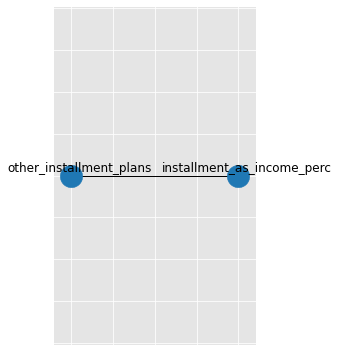

In [16]:
plot_graph(x_changes, 0)

# Titanic

In [17]:
data = pd.read_csv('./data/titanic.csv')
data.head()

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500


In [18]:
# from sklearn.datasets import load_breast_cancer
# X,y = load_breast_cancer(True)
# data = data.drop(['Name','Ticket','Cabin','Embarked','PassengerId'],axis=1)

data = data.drop(['Name'], axis=1)
data = data.dropna()
X_df = data.drop(['Survived'],axis=1)
y = data['Survived']

for d in X_df.columns[X_df.dtypes=='O']:
    le = LabelEncoder()    
    X_df[d] = le.fit_transform(X_df[d])
    print(d," .....   ",le.classes_)

X = X_df.values
y = y.values

Sex  .....    ['female' 'male']


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [20]:
clf_titanic = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)

In [21]:
idx_test = 5

ga_titanic = GAdvExample(feature_names=list(X_df.columns),
                sol_per_pop=30, num_parents_mating=10, cat_vars_ohe=None,
                 num_generations=100, n_runs=10, black_list=[],
                 verbose=False, beta=.9)

x_all, x_changes, x_sucess = ga_titanic.attack(clf_titanic, x=X_test[idx_test,:],x_train=X_train)

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 15.05it/s]


In [22]:
ga_titanic.results

,Pclass,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,P0,P1
0,3.000000,0.000000,2.000000,1.000000,1.000000,22.358300,0.600000,0.400000
1,3.000000,1.000000,2.000000,1.000000,1.000000,22.358300,0.100000,0.900000
2,2.000000,0.000000,2.000000,1.000000,1.000000,22.358300,0.100000,0.900000
